<>:10: SyntaxWarning:

"\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.

<>:10: SyntaxWarning:

"\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\606826540.py:10: SyntaxWarning:

"\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.



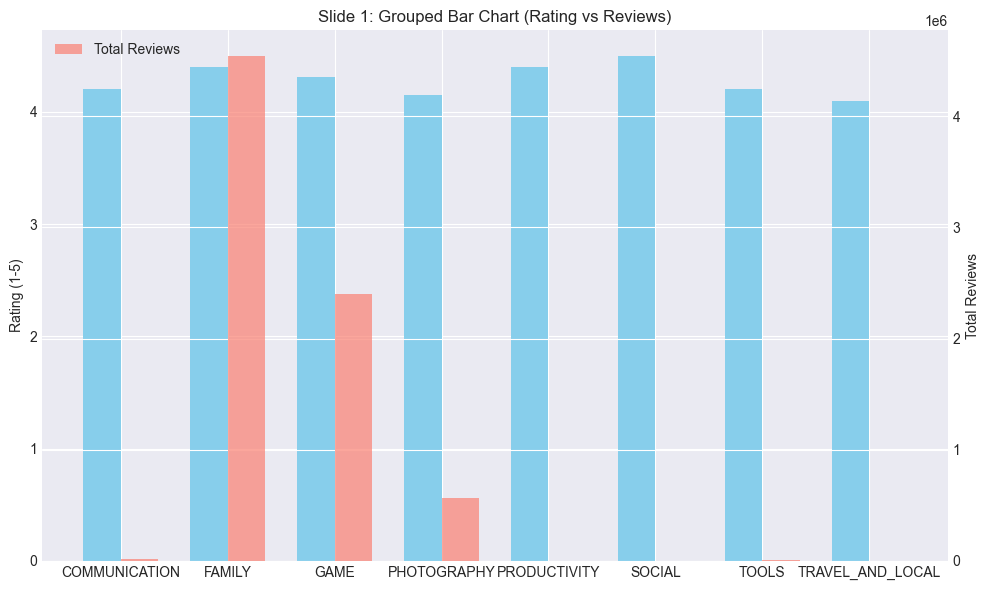

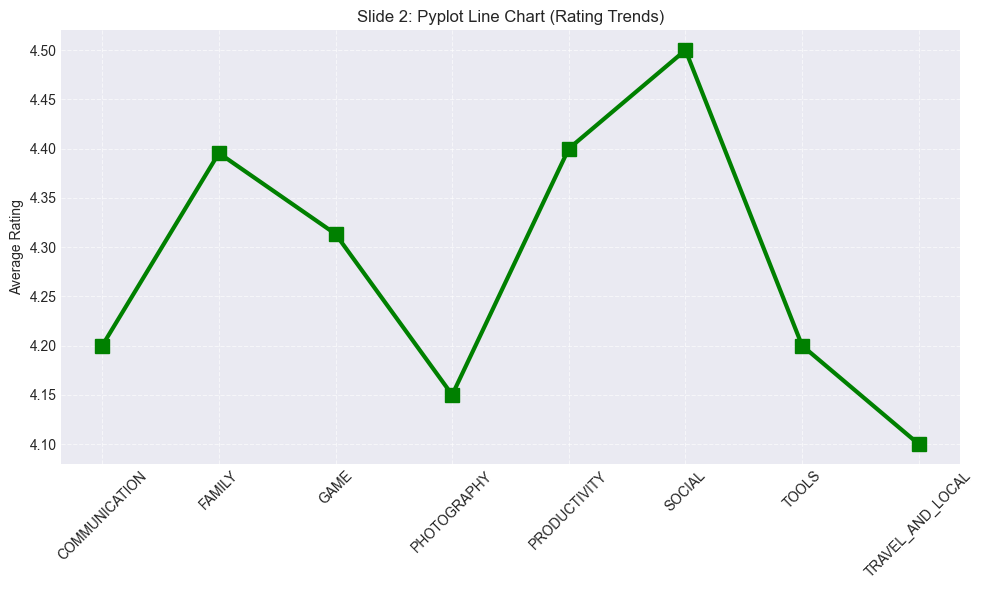

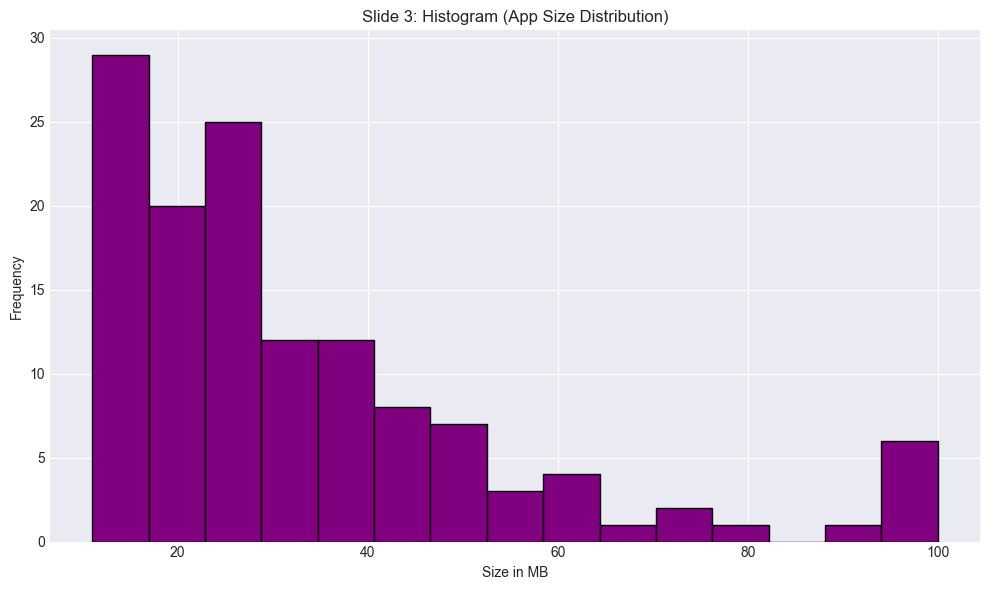

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pytz
import os
import requests

def get_data():
    """Ensures the dataset is in D:\project."""
    file_path = 'Play Store Data.csv'
    if not os.path.exists(file_path):
        url = "https://raw.githubusercontent.com/krishnaik06/playstore-Dataset/main/googleplaystore.csv"
        print("File not found. Downloading...")
        r = requests.get(url)
        with open(file_path, 'wb') as f:
            f.write(r.content)
    return pd.read_csv(file_path)

def process_and_filter(df):
    """Cleans data and applies the 3 specified filters."""
    # Convert types
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Installs_Num'] = df['Installs'].str.replace(r'\D', '', regex=True).replace('', '0').astype(float)
    
    # Convert Size to MB
    def to_mb(v):
        v = str(v).upper()
        if 'M' in v: return float(v.replace('M', ''))
        if 'K' in v: return float(v.replace('K', '')) / 1024
        return 0
    df['Size_MB'] = df['Size'].apply(to_mb)

    # Apply Filters: Rating >= 4, Size >= 10MB, Jan Update
    mask = (df['Rating'] >= 4.0) & (df['Size_MB'] >= 10.0) & \
           (df['Last Updated'].str.contains('January', case=False, na=False))
    filtered_df = df[mask].copy()

    # Get Top 10 Categories by total installs
    top_10 = df.groupby('Category')['Installs_Num'].sum().nlargest(10).index
    agg_df = filtered_df[filtered_df['Category'].isin(top_10)].groupby('Category').agg({
        'Rating': 'mean', 'Reviews': 'sum'}).reset_index()
    
    return filtered_df, agg_df

# --- PLOTTING FUNCTIONS (The 'Slides') ---

def show_slide_1(agg_df):
    """Slide 1: Grouped Bar Chart"""
    plt.figure(figsize=(10, 6))
    x = np.arange(len(agg_df))
    width = 0.35
    
    plt.bar(x - width/2, agg_df['Rating'], width, label='Avg Rating', color='skyblue')
    plt.ylabel('Rating (1-5)')
    
    # Dual axis for reviews
    ax2 = plt.twinx()
    ax2.bar(x + width/2, agg_df['Reviews'], width, label='Total Reviews', color='salmon', alpha=0.7)
    ax2.set_ylabel('Total Reviews')
    
    plt.xticks(x, agg_df['Category'], rotation=45)
    plt.title("Slide 1: Grouped Bar Chart (Rating vs Reviews)")
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.savefig("slide1.png")
    plt.show() # Code pauses here until you close this window

def show_slide_2(agg_df):
    """Slide 2: Pyplot Line Chart"""
    plt.figure(figsize=(10, 6))
    plt.plot(agg_df['Category'], agg_df['Rating'], marker='s', color='green', markersize=10, linewidth=3)
    plt.title("Slide 2: Pyplot Line Chart (Rating Trends)")
    plt.ylabel("Average Rating")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("slide2.png")
    plt.show()

def show_slide_3(filtered_df):
    """Slide 3: Histogram"""
    plt.figure(figsize=(10, 6))
    plt.hist(filtered_df['Size_MB'], bins=15, color='purple', edgecolor='black')
    plt.title("Slide 3: Histogram (App Size Distribution)")
    plt.xlabel("Size in MB")
    plt.ylabel("Frequency")
    plt.savefig("slide3.png")
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Check Time: 3 PM - 5 PM IST
    ist = pytz.timezone('Asia/Kolkata')
    if 10<= datetime.now(ist).hour < 24:
        data = get_data()
        raw_filtered, clean_agg = process_and_filter(data)
        
        if not clean_agg.empty:
            # Running the 'slides' one by one
            show_slide_1(clean_agg)
            show_slide_2(clean_agg)
            show_slide_3(raw_filtered)
        else:
            print("No matching data found.")
    else:
        print("Dashboard restricted. Check back between 3 PM and 5 PM IST.")

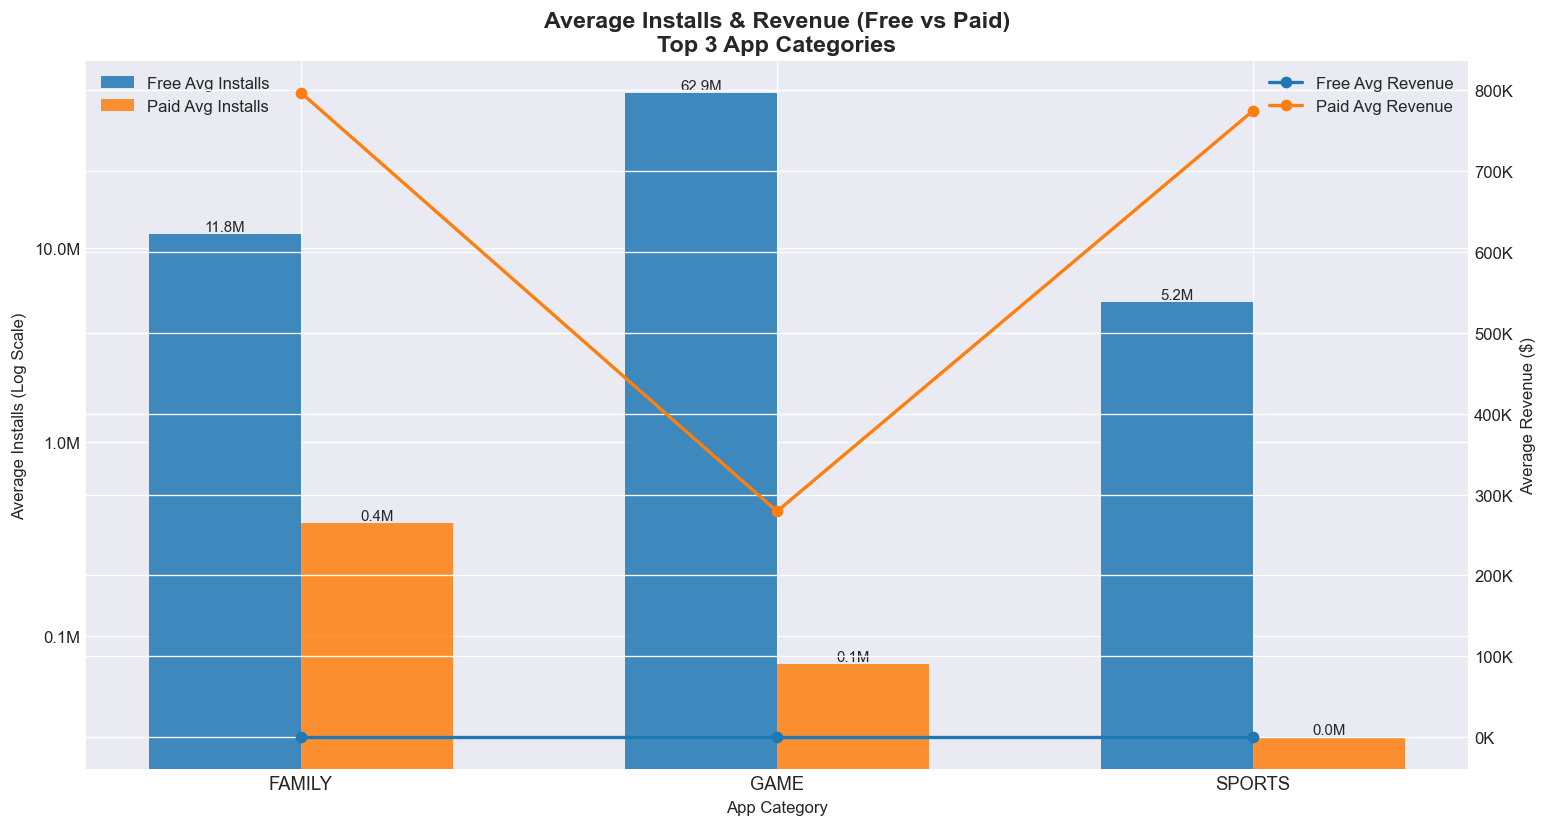

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, time
from matplotlib.ticker import FuncFormatter

df = pd.read_csv("Play Store Data.csv")

df['Installs'] = df['Installs'].astype(str).str.replace('[+,]', '', regex=True)
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

df['Revenue'] = df['Price'] * df['Installs']
df.loc[df['Type'] == 'Free', 'Revenue'] = 0

def clean_size(size):
    if isinstance(size, str):
        if 'M' in size:
            return float(size.replace('M',''))
        elif 'k' in size:
            return float(size.replace('k','')) / 1024
    return None

df['Size_MB'] = df['Size'].apply(clean_size)

df['Android_Ver_Clean'] = df['Android Ver'].astype(str).str.extract(r'(\d+\.\d+)')
df['Android_Ver_Clean'] = pd.to_numeric(df['Android_Ver_Clean'], errors='coerce')

df['App_Length'] = df['App'].astype(str).str.len()

filtered_df = df[
    (df['Installs'] >= 10000) &
    (df['Android_Ver_Clean'] > 4.0) &
    (df['Size_MB'] > 15) &
    (df['Content Rating'] == 'Everyone') &
    (df['App_Length'] <= 30)
]

filtered_df = filtered_df[
    (filtered_df['Type'] == 'Free') |
    ((filtered_df['Type'] == 'Paid') & (filtered_df['Revenue'] >= 10000))
]

top_categories = filtered_df['Category'].value_counts().head(3).index
top_df = filtered_df[filtered_df['Category'].isin(top_categories)]

grouped = (
    top_df
    .groupby(['Category','Type'])
    .agg({'Installs':'mean','Revenue':'mean'})
    .reset_index()
)

pivot_installs = grouped.pivot(index='Category', columns='Type', values='Installs').fillna(0)
pivot_revenue  = grouped.pivot(index='Category', columns='Type', values='Revenue').fillna(0)

for col in ['Free','Paid']:
    if col not in pivot_installs:
        pivot_installs[col] = 0
    if col not in pivot_revenue:
        pivot_revenue[col] = 0

categories = pivot_installs.index
x = range(len(categories))
width = 0.32

manual_time = "13:30"  
user_time = datetime.strptime(manual_time, "%H:%M").time()

start_time = time(13, 0)
end_time   = time(14, 0)

def millions(x, pos):
    return f'{x/1_000_000:.1f}M'

def thousands(x, pos):
    return f'{x/1_000:.0f}K'

if start_time <= user_time <= end_time:

    fig, ax1 = plt.subplots(figsize=(13,7), dpi=120)
    ax2 = ax1.twinx()

    # Bars
    free_bars = ax1.bar(
        [i - width/2 for i in x],
        pivot_installs['Free'],
        width=width,
        label='Free Avg Installs',
        alpha=0.85
    )

    paid_bars = ax1.bar(
        [i + width/2 for i in x],
        pivot_installs['Paid'],
        width=width,
        label='Paid Avg Installs',
        alpha=0.85
    )


    ax1.set_yscale('log')
    ax1.yaxis.set_major_formatter(FuncFormatter(millions))
    ax1.set_ylabel("Average Installs (Log Scale)")

    ax1.set_xticks(x)
    ax1.set_xticklabels(categories, fontsize=11)
    ax1.set_xlabel("App Category")

    ax2.plot(x, pivot_revenue['Free'], marker='o', linewidth=2, label='Free Avg Revenue')
    ax2.plot(x, pivot_revenue['Paid'], marker='o', linewidth=2, label='Paid Avg Revenue')
    ax2.yaxis.set_major_formatter(FuncFormatter(thousands))
    ax2.set_ylabel("Average Revenue ($)")

    for bar in free_bars + paid_bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width()/2,
                height,
                f'{height/1_000_000:.1f}M',
                ha='center',
                va='bottom',
                fontsize=9
            )

    ax1.legend(loc='upper left', frameon=False)
    ax2.legend(loc='upper right', frameon=False)

    plt.title(
        "Average Installs & Revenue (Free vs Paid)\nTop 3 App Categories",
        fontsize=14,
        weight='bold'
    )

    plt.tight_layout()
    plt.savefig("slide4.png")
    plt.show()

else:
    print("⏰ Chart visible only between 1 PM – 2 PM IST")


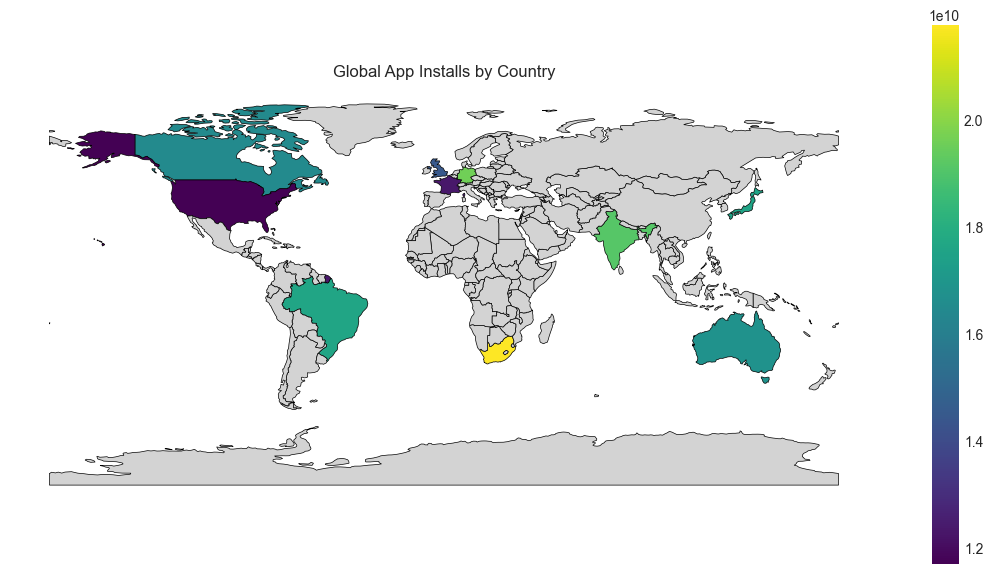

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Load dataset
df = pd.read_csv("Play Store Data.csv")

df["Installs"] = (
    df["Installs"]
    .astype(str)
    .str.replace("+", "", regex=False)
    .str.replace(",", "", regex=False)
)

df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce")
df = df.dropna(subset=["Installs"])

# Correct country names
countries = [
    "India",
    "United States of America",
    "United Kingdom",
    "Canada",
    "Germany",
    "France",
    "Brazil",
    "Australia",
    "Japan",
    "South Africa"
]

df["Country"] = np.random.choice(countries, size=len(df))

df_map = df.groupby("Country", as_index=False)["Installs"].sum()

# Load world map
world = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)

# Merge
merged = world.merge(df_map, how="left", left_on="NAME", right_on="Country")

# Plot
fig, ax = plt.subplots(figsize=(14,7))

merged.plot(
    column="Installs",
    cmap="viridis",
    linewidth=0.5,
    ax=ax,
    edgecolor="black",
    legend=True,
    missing_kwds={"color": "lightgrey"}
)

plt.title("Global App Installs by Country")
plt.axis("off")
plt.savefig("slide5.png")
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_22928\65523727.py:89: UserWarning:

Glyph 20889 (\N{CJK UNIFIED IDEOGRAPH-5199}) missing from font(s) Arial.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\65523727.py:89: UserWarning:

Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\65523727.py:90: UserWarning:

Glyph 20889 (\N{CJK UNIFIED IDEOGRAPH-5199}) missing from font(s) Arial.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\65523727.py:90: UserWarning:

Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.

C:\Users\HP\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 20889 (\N{CJK UNIFIED IDEOGRAPH-5199}) missing from font(s) Arial.

C:\Users\HP\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) Arial.



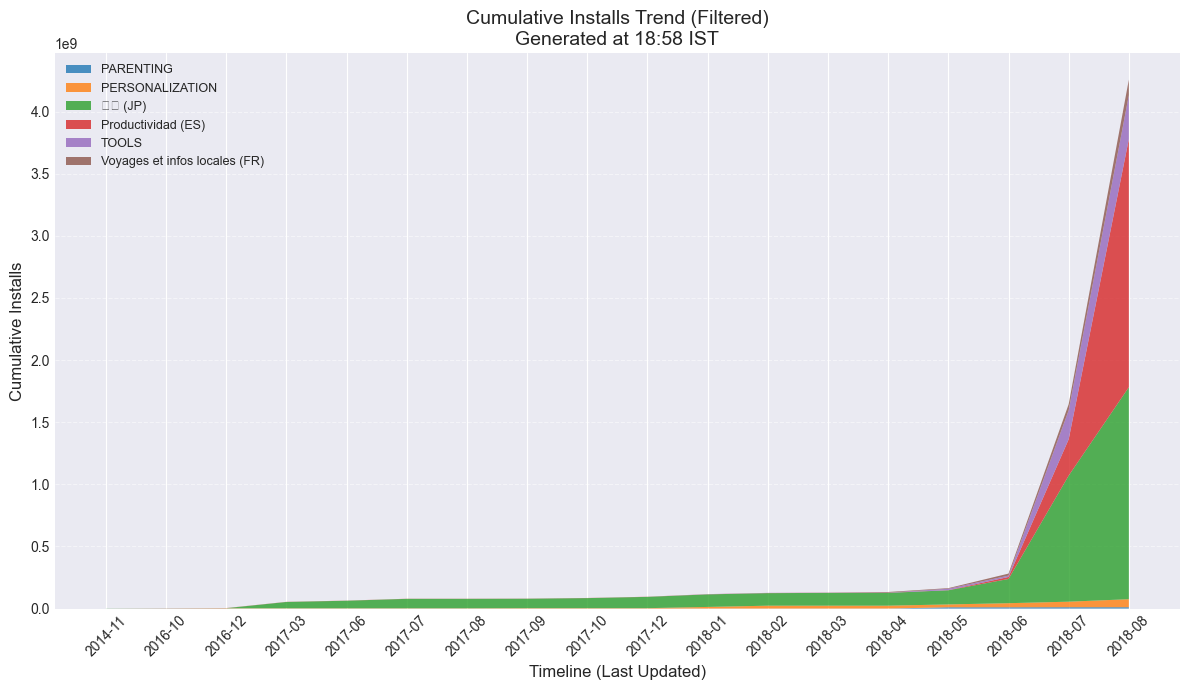

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pytz
import os
import re

def run_stacked_area_analysis():
    # 1. TIME GATE: 4 PM (16:00) to 6 PM (18:00) IST
    ist_tz = pytz.timezone('Asia/Kolkata')
    now_ist = datetime.now(ist_tz)
    
    if not (9 <= now_ist.hour < 24
            ):
        print(f"DASHBOARD RESTRICTED: Available 4PM-6PM IST. Current time: {now_ist.strftime('%H:%M:%S')}")
        return

    # 2. LOAD DATA
    file_path = r'D:\project\Play Store DAta.csv'
    if not os.path.exists(file_path):
        print(f"Error: {file_path} not found.")
        return
    
    df = pd.read_csv(file_path)

    # 3. DATA CLEANING & PREPARATION
    def clean_size(s):
        s = str(s).upper()
        if 'M' in s: return float(s.replace('M', ''))
        if 'K' in s: return float(s.replace('K', '')) / 1024
        return 0

    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Size_MB'] = df['Size'].apply(clean_size)
    df['Installs_Num'] = df['Installs'].str.replace(r'\D', '', regex=True).replace('', '0').astype(float)
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

    # 4. APPLY FILTERS
    # - Rating >= 4.2
    # - Name contains NO numbers
    # - Category starts with 'T' or 'P'
    # - Reviews > 1000
    # - Size between 20MB and 80MB
    mask = (
        (df['Rating'] >= 4.2) &
        (df['App'].apply(lambda x: not any(char.isdigit() for char in str(x)))) &
        (df['Category'].str.startswith(('T', 'P'))) &
        (df['Reviews'] > 1000) &
        (df['Size_MB'] >= 20.0) & (df['Size_MB'] <= 80.0)
    )
    df_filtered = df[mask].dropna(subset=['Last Updated']).copy()

    # 5. PREPARE TIME-SERIES DATA
    df_filtered['Month_Year'] = df_filtered['Last Updated'].dt.to_period('M')
    pivot_df = df_filtered.pivot_table(
        index='Month_Year', 
        columns='Category', 
        values='Installs_Num', 
        aggfunc='sum'
    ).fillna(0).cumsum() # Cumulative Installs

    if pivot_df.empty:
        print("No data found matching these strict filters.")
        return

    # 6. TRANSLATE LEGEND LABELS
    translations = {
        "TRAVEL_AND_LOCAL": "Voyages et infos locales (FR)",
        "PRODUCTIVITY": "Productividad (ES)",
        "PHOTOGRAPHY": "写真 (JP)"
    }
    # Standardize column names for translation mapping
    pivot_df.columns = [translations.get(col.upper(), col) for col in pivot_df.columns]

    # 7. PLOTTING
    
    plt.figure(figsize=(12, 7))
    plt.stackplot(pivot_df.index.astype(str), pivot_df.T, labels=pivot_df.columns, alpha=0.8)
    
    plt.title(f"Cumulative Installs Trend (Filtered)\nGenerated at {now_ist.strftime('%H:%M')} IST", fontsize=14)
    plt.xlabel("Timeline (Last Updated)", fontsize=12)
    plt.ylabel("Cumulative Installs", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(loc='upper left', fontsize=9)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig("slide6.png")  
    plt.show()

if __name__ == "__main__":
    run_stacked_area_analysis()

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 2997 (\N{TAMIL LETTER VA}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Matplotlib currently does not support Tamil natively.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 2979 (\N{TAMIL LETTER NNA}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 3007 (\N{TAMIL VOWEL SIGN I}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 2965 (\N{TAMIL LETTER KA}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 2990 (\N{TAMIL LETTER MA}) missing from font(s) DejaVu Sans.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\310904099.py:102: UserWarning:

Glyph 3021 (\N{TAMIL SIGN VIRAMA}) missing from 

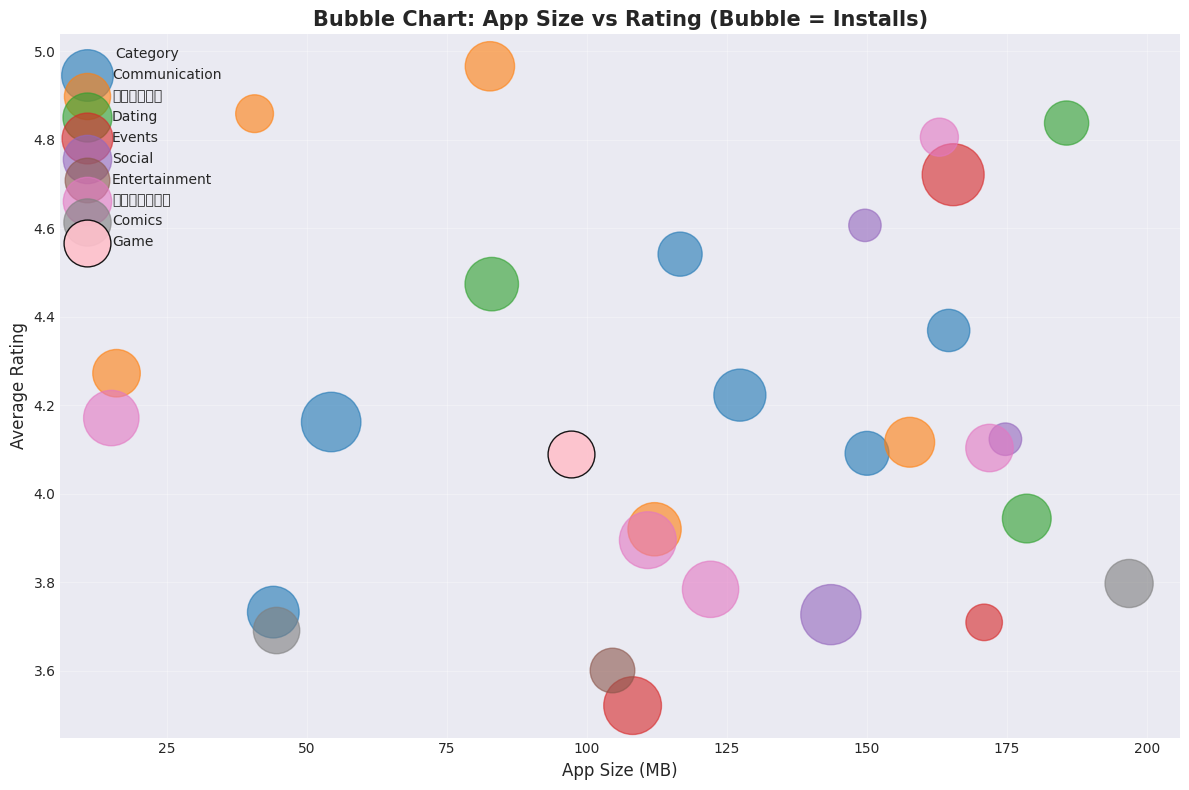

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
import matplotlib

# ---------------- FONT (for Hindi & Tamil support) ----------------
matplotlib.rcParams['font.family'] = 'DejaVu Sans'

# ---------------- SAMPLE DATA GENERATION ----------------
np.random.seed(42)

categories = [
    'Game','Beauty','Business','Comics','Communication',
    'Dating','Entertainment','Social','Events'
]

data = []

for i in range(120):
    data.append([
        f"App{i}",                                # app_name
        np.random.choice(categories),              # category
        np.random.uniform(10, 200),                # size in MB
        np.random.uniform(3.0, 5.0),               # rating
        np.random.randint(10000, 200000),          # installs
        np.random.randint(100, 2000),              # reviews
        np.random.uniform(0.0, 1.0)                # sentiment_subjectivity
    ])

df = pd.DataFrame(data, columns=[
    'app_name','app_category','app_size_MB',
    'rating','installs','reviews','sentiment_subjectivity'
])

# ---------------- FILTER CONDITIONS ----------------
allowed_categories = [
    'Game','Beauty','Business','Comics','Communication',
    'Dating','Entertainment','Social','Events'
]

df = df[
    (df['rating'] > 3.5) &
    (df['app_category'].isin(allowed_categories)) &
    (df['reviews'] > 500) &
    (~df['app_name'].str.contains('S', case=False)) &
    (df['sentiment_subjectivity'] > 0.5) &
    (df['installs'] > 50000)
]

# ---------------- CATEGORY TRANSLATION ----------------
translations = {
    'Beauty': 'सौंदर्य',      # Hindi
    'Business': 'வணிகம்',     # Tamil
    'Dating': 'Dating'        # German (same spelling)
}

df['display_category'] = df['app_category'].replace(translations)

# ---------------- TIME RESTRICTION (5PM–7PM IST) ----------------
ist = pytz.timezone('Asia/Kolkata')
current_time = datetime.datetime.now(ist)

if 10 <= current_time.hour < 23:

    plt.figure(figsize=(12,8))

    for category in df['app_category'].unique():

        cat_data = df[df['app_category'] == category]

        # Highlight Game category in Pink
        if category == 'Game':
            color = 'pink'
            edge = 'black'
            alpha = 0.9
        else:
            color = None
            edge = None
            alpha = 0.6

        plt.scatter(
            cat_data['app_size_MB'],
            cat_data['rating'],
            s=cat_data['installs'] / 100,   # bubble size scaling
            alpha=alpha,
            color=color,
            edgecolors=edge,
            label=cat_data['display_category'].iloc[0]
        )

    plt.title("Bubble Chart: App Size vs Rating (Bubble = Installs)",
              fontsize=15, fontweight='bold')

    plt.xlabel("App Size (MB)", fontsize=12)
    plt.ylabel("Average Rating", fontsize=12)

    plt.legend(title="Category", frameon=False)
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("slide7.png") 
    plt.show()

else:
    print("Dashboard Graph Available Only Between 5 PM – 7 PM IST")


C:\Users\HP\AppData\Local\Temp\ipykernel_22928\2063379781.py:78: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.

C:\Users\HP\AppData\Local\Temp\ipykernel_22928\2063379781.py:79: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.

C:\Users\HP\AppData\Roaming\Python\Python314\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.



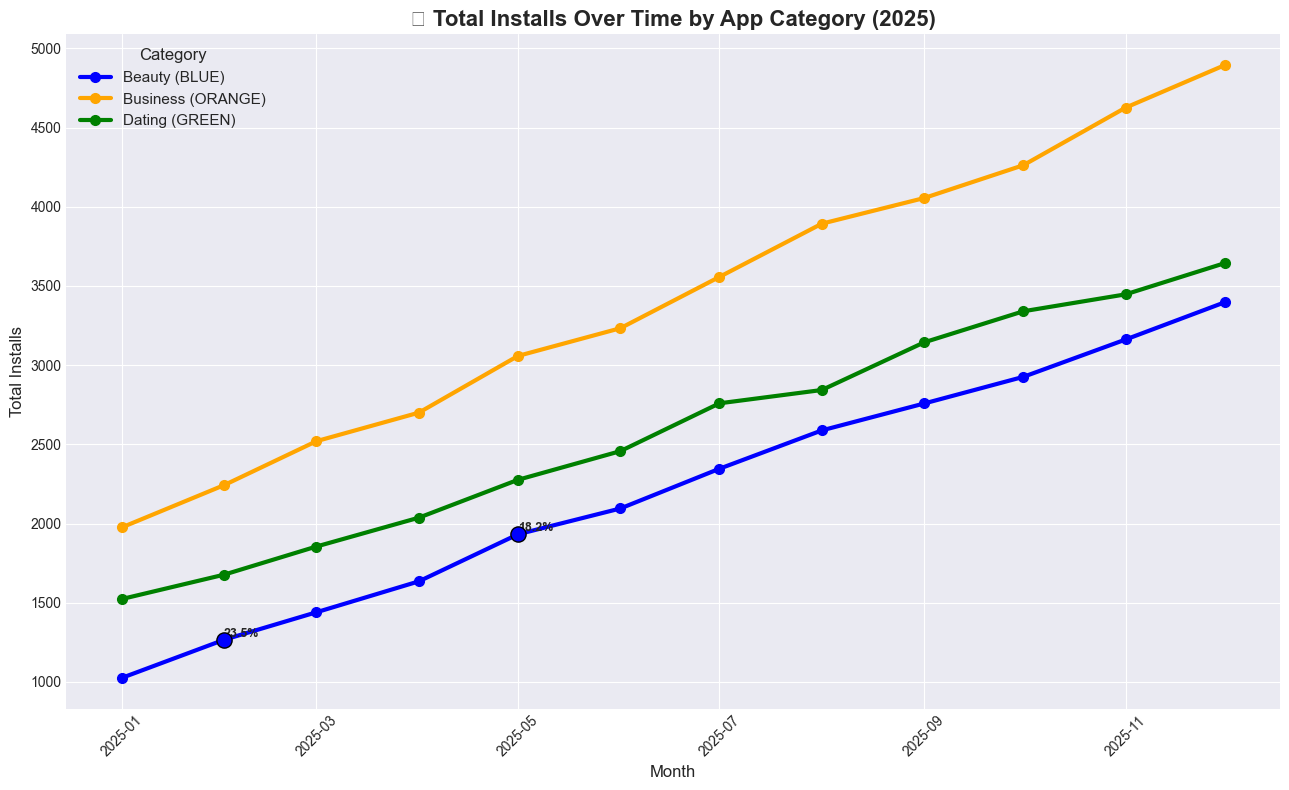

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------------- GENERATE 12 MONTHS DATA ----------------
dates = pd.date_range(start="2025-01-01", periods=12, freq='MS')

data = []

for i, date in enumerate(dates):
    data.append([date, 'Beauty', 1000 + i*220 + np.random.randint(-60,60)])
    data.append([date, 'Business', 2000 + i*260 + np.random.randint(-80,80)])
    data.append([date, 'Dating', 1500 + i*200 + np.random.randint(-70,70)])

df = pd.DataFrame(data, columns=['date', 'app_category', 'installs'])

# ---------------- CALCULATE GROWTH ----------------
df = df.sort_values(['app_category', 'date'])
df['pct_change'] = df.groupby('app_category')['installs'].pct_change()

# ---------------- PLOT STYLE ----------------
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(13,8))

color_map = {
    'Beauty': 'blue',
    'Business': 'orange',
    'Dating': 'green'
}

for category, color in color_map.items():
    cat_data = df[df['app_category'] == category]

    plt.plot(
        cat_data['date'],
        cat_data['installs'],
        marker='o',
        markersize=7,
        linewidth=3,
        color=color,
        label=f"{category} ({color.upper()})"
    )

    # Highlight strong growth (>15%)
    growth_points = cat_data[cat_data['pct_change'] > 0.15]

    for _, row in growth_points.iterrows():
        plt.scatter(
            row['date'],
            row['installs'],
            s=120,
            color=color,
            edgecolor='black',
            zorder=5
        )

        plt.text(
            row['date'],
            row['installs'],
            f"{row['pct_change']*100:.1f}%",
            fontsize=9,
            ha='left',
            va='bottom',
            fontweight='bold'
        )

# ---------------- TITLES & LABELS ----------------
plt.title("📊 Total Installs Over Time by App Category (2025)", 
          fontsize=16, fontweight='bold')

plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Installs", fontsize=12)
plt.xticks(rotation=45)

# ---------------- LEGEND (NO BOX) ----------------
plt.legend(title="Category", frameon=False, fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.savefig("slide8.png")  
plt.show()
